### Вопрос 1: Чем нейросети отличаются от линейных моделей а чем похожи?

В нейронной сети используется множество линейных моделей, между которыми существуют переходы. Также, внутренние линейные можели в сети могут содержать разное количество компонент.

### Вопрос 2: В чем недостатки полносвзяных нейронных сетей какая мотивация к использованию свёрточных?

Полносвязная нейронная сеть отличается тем, что у нее присутствуют все связи с соседними нейронами. Архитектура получается достаточно сложной, усложняется процесс обучения, отсутсвует стохастика. 
Сверточная сеть отличается тем, что свертка элементов происходит с одинаковыми весами(в предположении, что объект может равновероятно находиться в каком угоно месте объекта). Сверточные сети более устойчивы к изменению данных, а также их процесс обучения проходит быстрее.

### Вопрос 3: Какие слои используются в современных нейронных сетях? Опишите как работает каждый слой и свою интуицию зачем он нужен.

### Вопрос 4: Может ли нейросеть решать задачу регрессии, какой компонент для этого нужно заменить в нейросети из лекции 1?

Да, может. Для нее выход каждого предсказательного слоя должен быть оптимизирован под минимизацию ошибки, а на выход должна быть получена действительная величина. На вход следующего слоя можно передавать отклонение от результата(как в композиции алгоритмов решающих деревьев)

### Вопрос 5: Почему обычные методы оптимизации плохо работают с нейросетями? А какие работают хорошо? Почему они работают хорошо?

Нейронные сети содержат большое количество переменных, которые сложно оптимизировать одновременно исходя из всего набора данных. Лучше работают стохастические методы, потомы как они упрощают вычисления, тем самым уменьшая время решения, а также помогают избегать сходимости к локальным оптимумам.

### Вопрос 6: Для чего нужен backprop, чем это лучше/хуже чем считать градиенты без него? Почему backprop эффективно считается на GPU?

Backprop необходим для более быстрого подсчета градиента функции, так как он основан на цепном правиле. Без него подсчет градиента занимал бы гораздо большее время. Эффективно считается на GPU, потому что его можно распараллелить, так как этот процесс состоит из перемножения матриц.

### Вопрос 7: Почему для нейросетей не используют кросс валидацию, что вместо неё? Можно-ли ее использовать?

Использовать можно, но процесс обучения займет много времени, при этом, вероятно, не дав большого выигрыша, потому что на уровне глубоких сетей различия не будут заметны.

In [1]:
import pandas as pd

In [2]:
answer = pd.DataFrame(data = [['Same', 1, 28, 28, 8],['Valid', 1, 26, 26,8 ], ['Valid', 2,14,14,8]], columns = ['Padding', 'Stride', 'Width', 'Height', 'Depth'])

In [3]:
answer

,Padding,Stride,Width,Height,Depth
0,Same,1,28,28,8
1,Valid,1,26,26,8
2,Valid,2,14,14,8


In [4]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [5]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run Modules.ipynb

Optimizer is implemented for you.

In [6]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

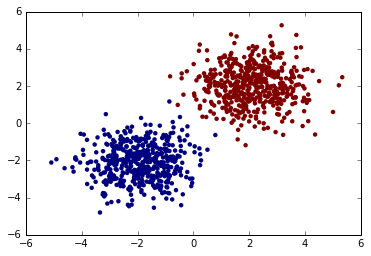

In [7]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [8]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

#Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(SoftMax())

Linear 2 -> 2
SoftMax



In [9]:
#Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())

In [10]:
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
SoftMax



In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [12]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [13]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

ValueError: operands could not be broadcast together with shapes (128,2) (128,4) 